In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
data = pd.read_csv("../2016_2020_alldata_eng_unify.csv", index_col=0)

In [13]:
train_data = data.query("season != 2020 & (eventType == 'SHOT' or eventType == 'GOAL')")
test_data = data.query("season == 2020 & (eventType == 'SHOT' or eventType == 'GOAL')")

# Logistic regression

In [46]:
X = train_data["distanceToGoal"]
y = train_data["isGoal"][X.isnull() == False]
X = X[X.isnull() == False]

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y)

# Data scaling
scaler = StandardScaler()

# If X_train and X_valid are single features, use the following lines
X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_valid_scaled = scaler.transform(X_valid.values.reshape(-1, 1))

# Data whitening using PCA
pca = PCA(whiten=True)
X_train_whitened = pca.fit_transform(X_train_scaled)
X_valid_whitened = pca.transform(X_valid_scaled)

# Model training
regressor = LogisticRegression(solver='saga', max_iter=100000, verbose=0)
regressor.fit(X_train_whitened, y_train)

# Validation
validation_predictions = regressor.predict(X_valid_whitened)
validation_probs = regressor.predict_proba(X_valid_whitened)
score = accuracy_score(y_valid, preds)

print("Accuracy:", score)

Accuracy: 0.9055885441913072


In [69]:
np.bincount(validation_predictions)

array([99024], dtype=int64)

# Graphiques

In [70]:
goal_prob = validation_probs[:,1]

Arguments fonction :

- predictions: dictionnaire avec key = nom du modèle et values sont les prédictions
- ground_truth: les vrais y (validation ou test)

## Fonction pour courbe ROC

In [252]:
def plot_roc_curves(predictions, ground_truth):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 8))
    
    for model_name, model_predictions in predictions.items():
        goal_prob = model_predictions[:, 1]
        fpr, tpr, _ = roc_curve(ground_truth, goal_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

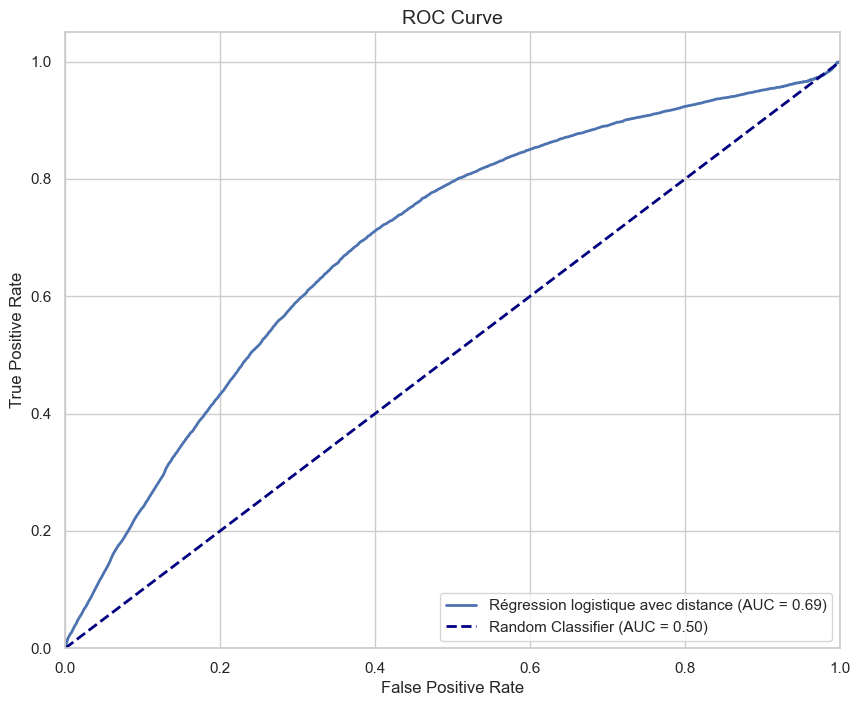

In [253]:
predictions = {
    'Régression logistique avec distance': validation_probs,
}
ground_truth = y_valid
plot_roc_curves(predictions, ground_truth)

## Fonction pour le taux de buts

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_goal_rates(predictions, ground_truth, bin_width=5):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 8))

    for model_name, model_predictions in predictions.items():
        goal_prob = model_predictions[:, 1]  # Assuming second column is the probability of a goal

        # Lists to hold data for the current model
        model_percentiles = []
        model_goal_rates = []

        for lower_bound in np.arange(0, 100, bin_width):
            upper_bound = lower_bound + bin_width
            mask = (goal_prob >= np.percentile(goal_prob, lower_bound)) & (goal_prob < np.percentile(goal_prob, upper_bound))

            total_shots = np.sum(mask)
            total_goals = np.sum(ground_truth[mask])

            goal_rate = (total_goals / total_shots) * 100 if total_shots > 0 else 0

            # Append the data to the model-specific lists
            model_percentiles.append(lower_bound)
            model_goal_rates.append(goal_rate)

        # Plot the data for the current model with markers
        sns.lineplot(x=model_percentiles, y=model_goal_rates, label=model_name, marker='o')

    plt.gca().invert_xaxis()
    plt.xticks(np.arange(0, 101, 10))
    plt.yticks(np.arange(0, 101, 10))
    plt.xlabel('Model Probability Percentile', fontsize=12)
    plt.ylabel('Goal Rate (%)', fontsize=12)
    plt.title('Goal Rates by Probability Percentile', fontsize=14)
    plt.legend(title='Model')
    plt.show()

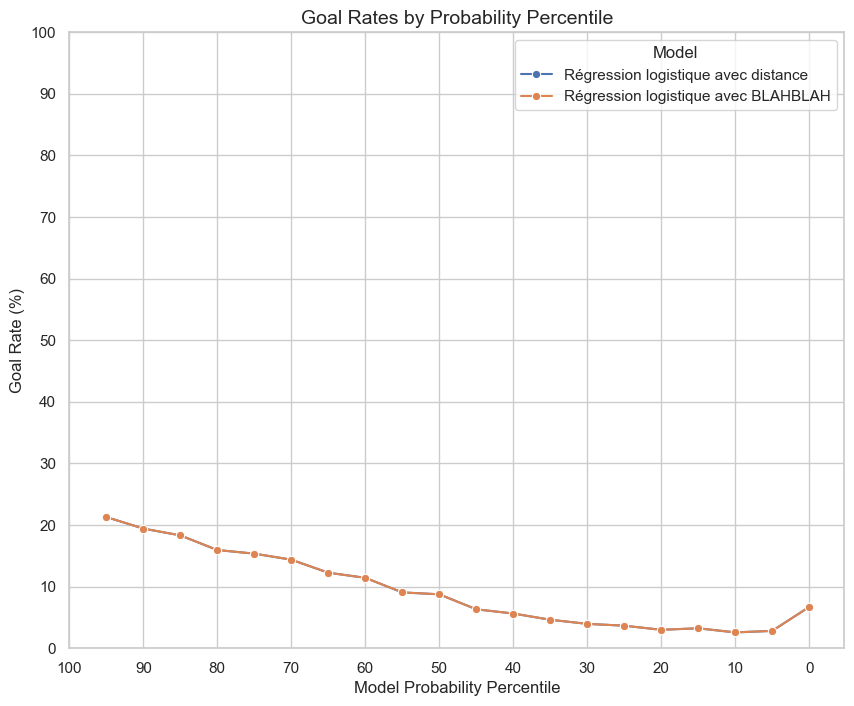

In [268]:
predictions = {
    'Régression logistique avec distance': validation_probs,
    'Régression logistique avec BLAHBLAH': validation_probs
}

plot_combined_goal_rates(predictions, ground_truth)

## Fonction pour plots cummulatifs

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_goals(predictions, ground_truth, bin_width=5):
    plt.figure(figsize=(10, 6))

    for model_name, model_predictions in predictions.items():
        df = pd.DataFrame({
            'Goal_prob': model_predictions[:, 1],  # Assuming the second column is the probability of a goal
            'isGoal': ground_truth
        })

        # Rank predictions by their probability, with higher probabilities getting higher ranks
        df['Percentile'] = df['Goal_prob'].rank(pct=True) * 100

        # Sort the DataFrame by Goal_prob in descending order
        df_sorted = df.sort_values(by='Goal_prob', ascending=False)

        # Calculate cumulative sum of goals
        df_sorted['Cumulative_Goals'] = df_sorted['isGoal'].cumsum()
        df_sorted['Total_Goals'] = df_sorted['isGoal'].sum()

        # Calculate cumulative proportion of goals
        df_sorted['Cumulative_Prop'] = df_sorted['Cumulative_Goals'] / df_sorted['Total_Goals']

        # Group by percentile and take the last value (highest within each percentile)
        df_grouped = df_sorted.groupby(pd.cut(df_sorted['Percentile'], np.arange(0, 100+bin_width, bin_width))).last()

        # Plot
        plt.plot(df_grouped['Percentile'], df_grouped['Cumulative_Prop'], marker='o', label=model_name)

    plt.xticks(np.arange(0, 101, 10))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.gca().invert_xaxis()
    plt.xlabel('Model Probability Percentile', fontsize=12)
    plt.ylabel('Cumulative Proportion of Goals', fontsize=12)
    plt.title('Cumulative Proportion of Goals by Probability Percentile', fontsize=14)
    plt.legend()
    plt.show()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_26424\95562747.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_sorted.groupby(pd.cut(df_sorted['Percentile'], np.arange(0, 100+bin_width, bin_width))).last()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_26424\95562747.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_sorted.groupby(pd.cut(df_sorted['Percentile'], np.arange(0, 100+bin_width, bin_width))).last()


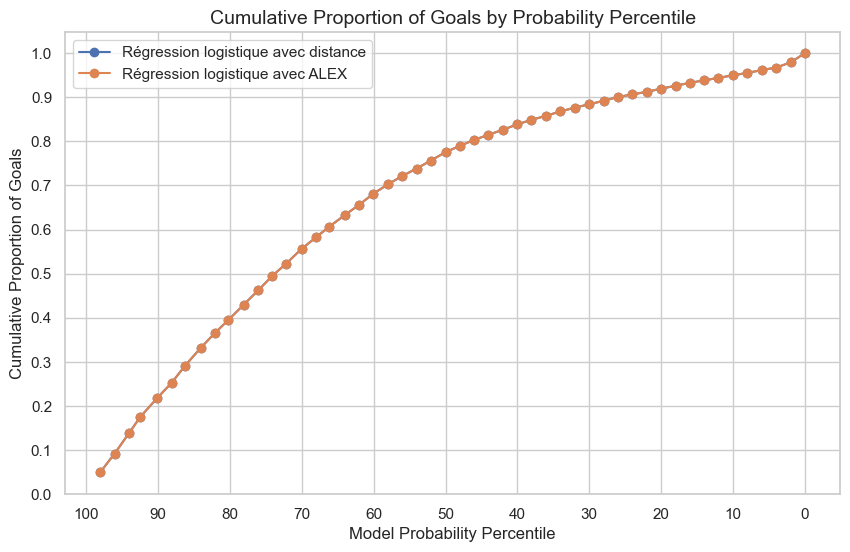

In [259]:
predictions = {
    'Régression logistique avec distance': validation_probs,
    'Régression logistique avec ALEX': validation_probs
}

plot_cumulative_goals(predictions, ground_truth, bin_width=2)

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curves(predictions_dict, y_test, n_bins=10):
    """
    Plots calibration curves for a given set of predicted probabilities on a single graph.
    
    Parameters:
    predictions_dict: dict, a dictionary where keys are model names and values are predicted probabilities
    y_test: array-like of shape (n_samples,), true binary labels
    n_bins: int, the number of bins to use for calibration
    """
    
    # Set the seaborn style
    sns.set(style='whitegrid')

    # Create a figure with the specified size (1000px by 800px)
    fig, ax = plt.subplots(figsize=(10, 8))  # 1000px / 100 dpi = 10 inches, 800px / 100 dpi = 8 inches

    # Plot calibration curves
    for model_name, y_prob in predictions_dict.items():

        goal_prob = y_prob[:, 1]  # Assuming the second column is the probability of a goal
        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_test, goal_prob, n_bins=n_bins)
        
        # Plot the calibration curve
        ax.plot(prob_pred, prob_true, marker='o', label=model_name)

    ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability (Positive Class: 1)', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title('Calibration Plot', fontsize=14)
    ax.legend(loc='best')
    plt.show()

In [261]:
X_test = test_data["distanceToGoal"]
y_test = test_data["isGoal"][X_test.isnull() == False]
X_test = X_test[X_test.isnull() == False]

probs = regressor.predict_proba(pca.transform(scaler.transform(X_test.values.reshape(-1, 1))))

In [262]:
#random unif
temp = np.random.uniform(0, 1, probs.shape[0])
probs2 = np.array([temp, 1-temp]).T

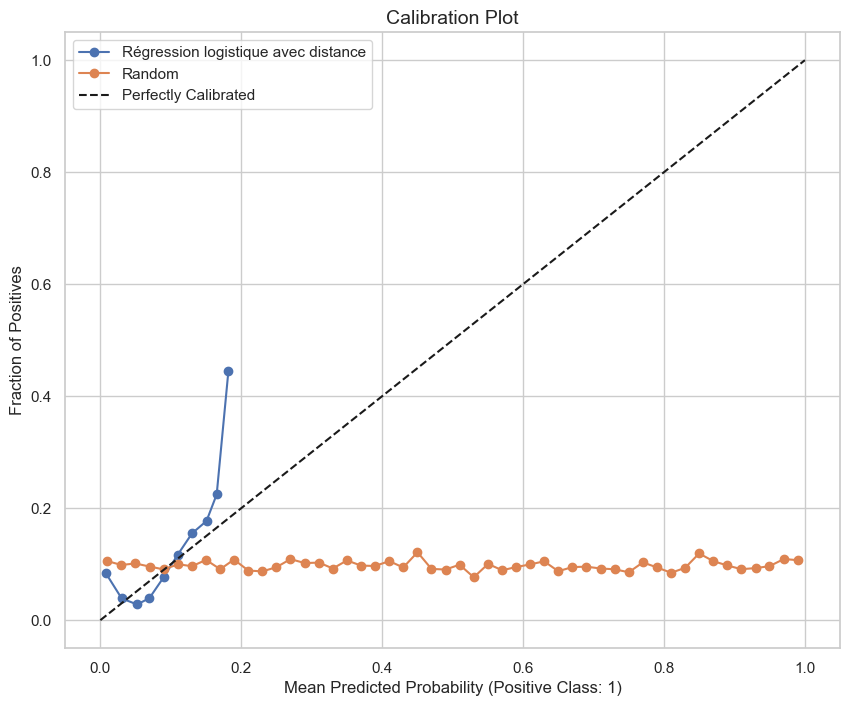

In [263]:
predictions = {
    'Régression logistique avec distance': probs,
    'Random': probs2
}

plot_calibration_curves(predictions_dict=predictions, y_test=y_test, n_bins=50)